# Bayesian Neural Network

In [8]:
import os
import sys
import matplotlib.pyplot as plt
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
m = bi(platform='cpu')

jax.local_device_count 1


## Gaussian neural network
### Simulate data
We generate training and test data from a Bayesian neural network model. in order evaluate accuracy of the model.


jax.local_device_count 16


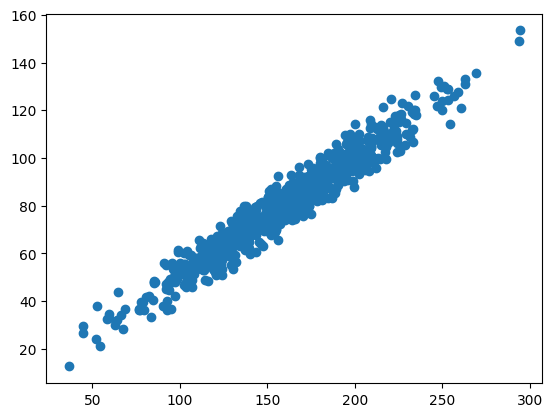

In [2]:

# setup platform------------------------------------------------
m = bi(platform='cpu')
alpha= 0.6
beta = 0.5
sigma= 5
x=m.dist.normal(160, 40,sample=True,shape=(1000,))
lk=alpha+beta*x
y=bi.dist.normal(lk, sigma,sample=True,seed=2)
data=jnp.array([x,y]).T

def split_train_test(arr):
    # Get the length of the array
    n = arr.shape[0]
    
    # Calculate the split index (80% for training)
    train_idx = int(n * 0.8)
    
    # Generate a random permutation of indices
    key = jax.random.PRNGKey(0)  # You can use a fixed key for reproducibility
    permuted_indices = jax.random.permutation(key, n)
    
    # Split the permuted indices
    train_indices = permuted_indices[:train_idx]
    test_indices = permuted_indices[train_idx:]
    
    # Split the original array based on the indices
    train_set = arr[train_indices]
    test_set = arr[test_indices]
    
    return train_set, test_set

train, test = split_train_test(data)

dataTrain= dict(X=train[:,0].reshape((train[:,0].shape[0],1)),Y=train[:,1].reshape((train[:,0].shape[0],1)))

m.data_on_model=dataTrain

plt.scatter(dataTrain['X'], dataTrain['Y'])

In [112]:
def get_data(N=50, D_X=2, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = jnp.linspace(-1.3, 1.3, N_test)
    X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

    return X, Y, X_test
X, Y, X_test = get_data()

In [ ]:
X=(X - jnp.mean(X))/jnp.std(X)
m.data_on_model=dict(X=X, Y=Y) 
def activation(x):
    return jnp.tanh(x)
# ! This work with only one hidden layer
# ! however i can't make it run on a linear relationship
# define model ------------------------------------------------
def model(X, Y,  D_H=5, D_Y=1):  
    N, D_X = X.shape
    # sample first layer (we put unit normal priors on all weights)
    # First hidden layer: Transforms input to N × D_H (hidden units)
    w1 = dist.normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H)),  name='w1',shape=(D_X,D_H))
    z1 = activation(jnp.matmul(X, w1))  # <= first layer of activations

    ## sample second layer
    ## Second hidden layer: Further transforms to N × D_H
    #w2 = dist.normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, #D_H)),  name='w2',shape=(D_H,D_H))
    #z2 = activation(jnp.matmul(z1, w2))  # <= second layer of activations

    # sample final layer of weights and neural network output
    # Final layer (z3) computes linear combination of second hidden layer
    w3 = dist.normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y)),  name='w3',shape=(D_H,D_Y))
    z3 = jnp.matmul(z1, w3)  # <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = dist.gamma(3.0, 1.0,name='prec_obs')
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    m.normal(z3, sigma_obs, obs=Y,shape=(N,D_Y),name='Y')



# Run sampler ------------------------------------------------
m.run(model, num_samples=500) 

(50, 1)
(50, 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

(50, 1)


sample: 100%|██████████| 1000/1000 [00:08<00:00, 111.52it/s, 255 steps of size 1.17e-02. acc. prob=0.91]


(50, 1)


[Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y'),
 Text(0.5, 1.0, 'Mean predictions with 90% CI')]

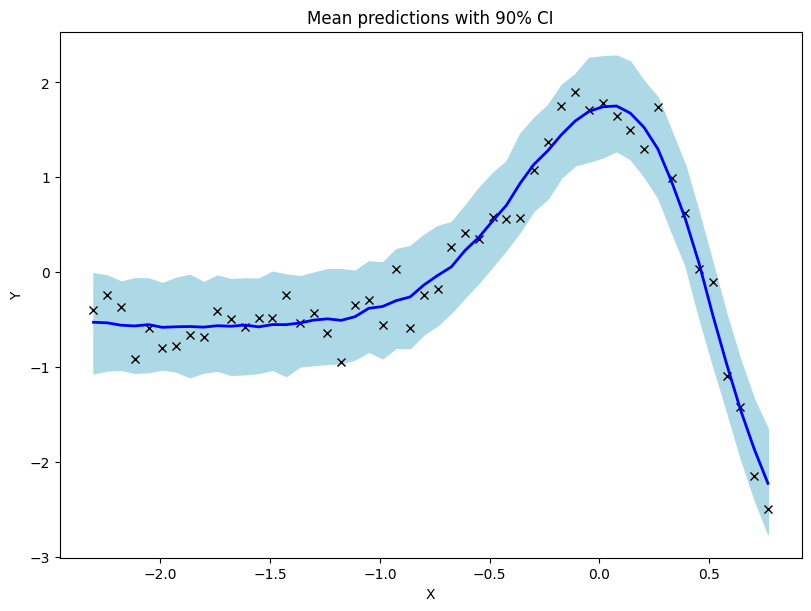

In [116]:
from numpyro import handlers
samples=m.sampler.get_samples()
vmap_args = (
    samples,
    random.split(rng_key_predict, 500 * 1),
)
predictions = vmap(
    lambda samples, rng_key: predict(model, rng_key, samples, X, D_H)
)(*vmap_args)

predictions = predictions[..., 0]
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X[:, 1], Y[:, 0], "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
ax.plot(X[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
